In [1]:
import os
import time
import random
import argparse
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

np.random.seed(7)
torch.manual_seed(0)


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

# Titolone

## PATH definition

In [3]:
# The path of the data
PATH = './ml-100k/u.data'
MODEL_PATH = './models/'

## Parameters definition

In [4]:
#@title hyperparameters definition
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed", 
	type=int, 
	default=42, 
	help="Seed")
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.2,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=256, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=30,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	type=int,
	default=32, 
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+', 
    default=[32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--out", 
	default=True,
	help="save model or not")


args = parser.parse_args("")

## Data preprocessing

In [5]:
# Train dataset is {train_positive} Union {train_negative}
class TrainDataset(Dataset):
    def __init__(self, table):
        self.users_list, self.items_list, self.relevance_list = [], [], []
        
        # For each user
        for _, user_id, _, train_positive, _, train_negative, _, _ in table.itertuples():

            # Add positive train interactions
            for item in train_positive:
                self.users_list.append(user_id)
                self.items_list.append(item)
                self.relevance_list.append(1.0)

            # Add negative train interactions
            for item in train_negative:
                self.users_list.append(user_id)
                self.items_list.append(item)
                self.relevance_list.append(0.0)

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self, idx):
        user_id = torch.tensor(self.users_list[idx], dtype = torch.long)
        item_id = torch.tensor(self.items_list[idx], dtype = torch.long)
        relevance = torch.tensor(self.relevance_list[idx], dtype = torch.float)

        return user_id, item_id, relevance

# Validation dataset is {valid_positive} Union {valid_negative}
class ValidationDataset(Dataset):
    def __init__(self, table):
        self.users_list, self.items_list, self.relevance_list = [], [], []
        
        # For each user
        for _, user_id, _, _, _, _, valid_positive, valid_negative in table.itertuples():

            # Add positive validation interactions
            for item in valid_positive:
                self.users_list.append(user_id)
                self.items_list.append(item)
                self.relevance_list.append(1.0)

            # Add negative validation interactions ##test
            for item in valid_negative:
                self.users_list.append(user_id)
                self.items_list.append(item)
                self.relevance_list.append(0.0)

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self, idx):
        user_id = torch.tensor(self.users_list[idx], dtype = torch.long)
        item_id = torch.tensor(self.items_list[idx], dtype = torch.long)
        relevance = torch.tensor(self.relevance_list[idx], dtype = torch.float)

        return user_id, item_id, relevance

# Complete train dataset is {train_positive} Union {train_negative} Union {valid_positive} Union {valid_negative}
class CompleteTrainDataset(Dataset):
    def __init__(self, train_dataset, valid_dataset):
        self.users_list = []
        self.users_list.extend(train_dataset.users_list)
        self.users_list.extend(valid_dataset.users_list)

        self.items_list = []
        self.items_list.extend(train_dataset.items_list)
        self.items_list.extend(valid_dataset.items_list)

        self.relevance_list = []
        self.relevance_list.extend(train_dataset.relevance_list)
        self.relevance_list.extend(valid_dataset.relevance_list)

        self.len = len(train_dataset) + len(valid_dataset)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        user_id = torch.tensor(self.users_list[idx], dtype = torch.long)
        item_id = torch.tensor(self.items_list[idx], dtype = torch.long)
        relevance = torch.tensor(self.relevance_list[idx], dtype = torch.float)

        return user_id, item_id, relevance

# Test dataset is {test_positive} Union {100 random samples from unknown}
class TestDataset(Dataset):
    def __init__(self, table, num_unknown=100):
        self.num_unknown = num_unknown
        self.users_list, self.items_list, self.relevance_list = [], [], []
        
        # For each user
        for _, user_id, test_positive, _, unknown, _, _, _ in table.itertuples():

            # Add positive test interactions
            for item in test_positive:
                self.users_list.append(user_id)
                self.items_list.append(item)
                self.relevance_list.append(1.0)

            # Add sampled unknown interactions
            for item in random.sample(list(unknown), self.num_unknown):
                self.users_list.append(user_id)
                self.items_list.append(item)
                self.relevance_list.append(np.nan)

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self, idx):
        user_id = torch.tensor(self.users_list[idx], dtype = torch.long)
        item_id = torch.tensor(self.items_list[idx], dtype = torch.long)
        relevance = torch.tensor(self.relevance_list[idx], dtype = torch.float)

        return user_id, item_id, relevance

In [6]:
def get_num_users_items(path):
        ratings = pd.read_csv(path,
                        sep = '\t',
                        names = ['user_id', 'item_id', 'rating', 'timestamp'],
                        )
        return (ratings['user_id'].nunique(), ratings['item_id'].nunique())

In [7]:
def data_loaders_from_data(path, batch_size):
    ratings = pd.read_csv(path,
                        sep = '\t',
                        names = ['user_id', 'item_id', 'rating', 'timestamp'],
                        )
    # THEORETICAL FRAMEWORK
    #
    # The dataset contains ratings of items by users
    #
    # For each couple (u, i) of a user and a item, we consider
    # the discrete random variable R(u, i) = "item i is relevant for user u"
    # R(u, i) € {0, 1} for every u, i
    # In this scenario "relevant" doesn't assume the usual meaning
    # it refers to a "relevance" by a reccomender system point of view
    # 
    # If a user u rated an item i, then he interacted with it
    # in this case we assume to have a realization r(u, i) = 1 of R(u, i)
    #
    # Since we only have items ratings in our dataset, we don't have any "negative"
    # realization of R(u, i), i.e. any realization r(u, i) = 0
    #
    # For this reason we make a sampling from the unrealized variables, i.e
    # the variables R(u, i) such in our dataset there is not a rating of item i by user u
    #
    # Given our final dataset, consisting in realizations of a subset of the variables {R(u, i): u user, i item}
    # we want to maximize the likelihood function of the model, i.e.
    # L = product of p(R(u, i) = r(u, i))
    #   = (product of p(R(u, i) = 1)) x (product of p(R(u, i) = 0)   splitting the products between positive and negative realizations
    #
    # Our model returns the value f(u, i) = p(R(u, i) = 1) i.e. the "probability of relevance of item i for user u"
    # Passing to maximize the log likelihood function we want to maximize:
    # log L = (sum of log p(R(u, i) = 1)) + (sum of log p(R(u,i) = 0))
    #       = (sum of log p(R(u, i) = 1)) + (sum of log (1 - p(R(u, i) = 1)))
    #       = (sum of log f(u, i)) + (sum of log (1 - f(u, i)))
    #       = BCE of f

    num_users = ratings['user_id'].nunique()
    num_items = ratings['item_id'].nunique()

    known_positive_size_list = list(ratings.groupby('user_id').size())

    # I want user indexing to start from 0
    ratings['user_id'] = ratings['user_id'] - 1

    # I want item indexing to start from 0
    ratings['item_id'] = ratings['item_id'] - 1

    # For each user consider the set of items of which we know he interacted with
    relevance_table = ratings.groupby('user_id')['item_id'].apply(set).reset_index().rename(columns = {'item_id': 'known_positive'})

    # Set of all items
    items_set = set(range(num_items))

    # For each user consider the set of items of which we have NO interaction information
    relevance_table['unknown'] = relevance_table['known_positive'].apply(lambda x: items_set - x)

    # We don't know any negative interaction
    # We create them by sampling:

    # For each user
    #     Random sample items for each known_positive
    #     Assume that the probability of interaction for those items with the user is 0.0

    # How many negative interactions to add for each user
    def num_ng(user_id):
        known_positive_size = known_positive_size_list[user_id]
        if known_positive_size <= 50:
            return known_positive_size * 4
        if known_positive_size <= 100:
            return known_positive_size * 2
        if known_positive_size <= 200:
            return known_positive_size
        return 10

    relevance_table['known_negative'] = relevance_table.apply(lambda row: set(random.sample(list(row['unknown']), num_ng(row['user_id']))), axis = 'columns')
    relevance_table['unknown']  = relevance_table['unknown'] - relevance_table['known_negative']

    # Put aside the last known positive interactions for testing models(i.e. leave-one-out evaluation method)
    # How to do it:

    #     Add column ranking how old is the interaction
    ratings['oldness'] = ratings['timestamp'].groupby(ratings['user_id']).rank(method = 'first', ascending = False)

    #     Get the most recent interaction for each user
    most_recent_interactions = ratings.groupby('oldness').get_group(1.0)

    #     Create column to add to relevance_table
    last_known_positive = most_recent_interactions.groupby('user_id')['item_id'].apply(set).reset_index().rename(columns = {'item_id': 'last_known_positive'})

    #     Add the column
    relevance_table = pd.merge(last_known_positive, relevance_table, on = 'user_id')
    relevance_table['known_positive'] = relevance_table['known_positive'] - relevance_table['last_known_positive']

    # Rename some columns
    relevance_table.rename(columns = {'last_known_positive' : 'test_positive', 'known_positive': 'train_positive', 'known_negative': 'train_negative'}, inplace='True')

    # Validation data
    relevance_table['validation'] = relevance_table.apply(lambda row: set(random.sample(list(row['train_positive'] | row['train_negative']), 1)), axis = 'columns')

    relevance_table['valid_positive'] = relevance_table.apply(lambda row: row['validation'] & row['train_positive'], axis = 'columns')
    relevance_table['valid_negative'] = relevance_table.apply(lambda row: row['validation'] & row['train_negative'], axis = 'columns')

    relevance_table['train_positive']  = relevance_table['train_positive'] - relevance_table['validation']
    relevance_table['train_negative']  = relevance_table['train_negative'] - relevance_table['validation']

    relevance_table.drop(columns = 'validation', inplace = True)

    #print(relevance_table)

    train_dataset = TrainDataset(relevance_table)
    validation_dataset = ValidationDataset(relevance_table)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    valid_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = True)
    complete_train_loader = DataLoader(CompleteTrainDataset(train_dataset, validation_dataset), batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(TestDataset(relevance_table), batch_size = 101, shuffle = False)

    return train_loader, valid_loader, complete_train_loader, test_loader

In [8]:
train_loader, valid_loader, complete_train_loader, test_loader = data_loaders_from_data(PATH, batch_size = 256)
num_users, num_items = get_num_users_items(PATH)

## Evaluation Metrics

In [9]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

# Models Definition


In [10]:
#trains and save the model and returns the lists of train_loss and validation_loss 
def train_model(model:nn.Module, train_loader: DataLoader, valid_loader: DataLoader, args):
    model = model.to(device)

    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # train, evaluation
    best_valid_loss = math.inf
    train_loss, valid_loss = [], []

    for epoch in tqdm(range(args.epochs)):
        model.train() # Enable dropout (if have).
        start_time = time.time()

        intermediate_train_loss = []
        for user, item, label in train_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            prediction = model(user, item)
            loss = loss_function(prediction, label)
            loss.backward()
            optimizer.step()
            intermediate_train_loss.append(loss.cpu().detach().item())
            #writer.add_scalar('loss/Train_loss', loss.item(), epoch)

        train_loss.append(np.array(intermediate_train_loss).mean())

        model.eval()

        intermediate_valid_loss = []
        for user, item, label in valid_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            prediction = model(user, item)
            loss = loss_function(prediction, label)

            intermediate_valid_loss.append(loss.cpu().detach().item())

        valid_loss.append(np.array(intermediate_valid_loss).mean())
        if valid_loss[epoch] < best_valid_loss:
            best_valid_loss = valid_loss[epoch]
            if args.out:
                if not os.path.exists(MODEL_PATH):
                    os.mkdir(MODEL_PATH)
                torch.save(model, 
                    '{}{}{}.pt'.format(MODEL_PATH, model.__class__.__name__, model.factor_num))
                
    losses = pd.DataFrame({"train loss":train_loss, "valid loss": valid_loss}, index=range(1, args.epochs+1))
    losses.to_csv('{}{}{}'.format(MODEL_PATH, model.__class__.__name__, model.factor_num))
    return train_loss, valid_loss


In [11]:
def plot_losses(model: nn.Module, train_loss, valid_loss):
    fig, ax = plt.subplot()
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss) +1), train_loss, label = "Training", color='r')
    plt.plot(range(1, len(valid_loss) +1), valid_loss, 'r--', label = "Validation")
    plt.legend()
    plt.title(model.__class__.__name__ + " losses with " + str(model.factor_num)+ " num factors")
    plt.xticks(np.arange(1,len(train_loss) + 1,2))
    #plt.ylim((0, 1))
    plt.xlabel("Epochs")
    plt.ylabel("BCE Loss")
    return plt


In [12]:
def plot_losses2(model: nn.Module, train_loss, valid_loss, ax):
    ax.plot(range(1, len(train_loss) +1), train_loss, label = "Training", color='blue')
    ax.plot(range(1, len(valid_loss) +1), valid_loss, label = "Validation", color = "green")
    ax.legend()
    ax.set_title(model.__class__.__name__ + " losses with " + str(model.factor_num)+ " num factors")
    ax.set_xticks(np.arange(1,len(train_loss) + 1,2))
    ax.set_ylim(0.25, 0.7)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("BCE Loss")
    return ax


## General Matrix Factorization (GMF)

In [13]:
class GMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

### Training and save of GMF model

In [14]:
gmf_model = GMF(args, num_users, num_items)
train_loss, valid_loss = train_model(gmf_model, train_loader, valid_loader,args)
pass

100%|██████████| 30/30 [00:59<00:00,  1.97s/it]


## Multi Layer Perceptron (MLP)

In [15]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(self.factor_num*2, self.layers[0]))

        for in_size, out_size in zip(self.layers[:-1], self.layers[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))

                                
        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

In [16]:
args.factor_num = 16
mlp_model = MLP(args, num_users, num_items)
train_loss, valid_loss = train_model(mlp_model, train_loader, valid_loader, args)

100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


TypeError: cannot unpack non-iterable AxesSubplot object

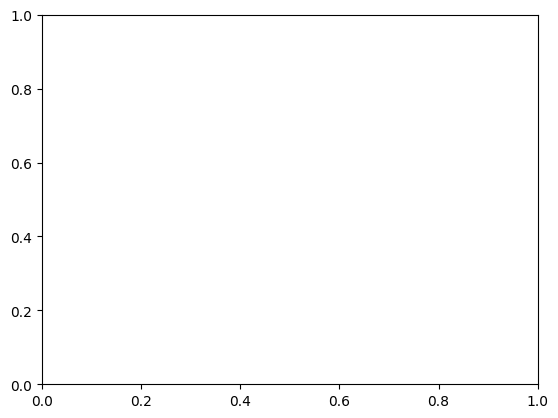

In [17]:
plot_losses(mlp_model, train_loss, valid_loss)

## Neural Matrix Factorization

In [18]:
class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        #GMF component
        self.embedding_user_gmf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item_gmf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output_gmf = nn.Linear(in_features=self.factor_num, out_features=8, bias = False)


        #MLP component
        self.layers = args.layers

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(self.factor_num*2, self.layers[0]))

        for in_size, out_size in zip(self.layers[:-1], self.layers[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        ##Models fusion
        self.mixing_layers = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
            #nn.Dropout(p = 0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            #nn.Dropout(p = 0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, user_indices, item_indices):
        #GMF forward
        # (batch_size , factor_num)
        user_embedding_gmf = self.embedding_user_gmf(user_indices)
        item_embedding_gmf = self.embedding_item_gmf(item_indices)

        # (bacth_size , factor_num)
        element_product = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # (batch_size, 8)
        logits_gmf = self.affine_output_gmf(element_product)

        # (batch_size, 8)
        ratings_gmf = logits_gmf

        #MLP forward
        # (batch_size, factor_num)
        user_embedding_mlp = self.embedding_user_mlp(user_indices)

        # (bacth_size, factor_num)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        # (batch_size, 2* factor_num)
        vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            # (batch_size, in_size) -> (batch_size, out_size)
            vector = self.fc_layers[idx](vector)
            if idx != len(self.fc_layers)-1:
                vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            vector = nn.Dropout(p=0.5)(vector)
        # (batch_size, 8)
        ratings_mlp =  vector

        #Models fusion
        # (batch_size, 8) cat (batch_size, 8) -> (batch_size, 16)
        ratings = torch.cat([ratings_gmf, ratings_mlp], dim = 1)

        return self.mixing_layers(ratings).squeeze()       

In [19]:
#Gio
class NCF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NCF, self).__init__()
        self.num_users = num_users # 943
        self.num_items = num_items # ~1700
        self.factor_num = args.factor_num # 32
        self.layers = args.layers
        # GMF
        self.embedding_user_gmf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num) # size: (BATCH_SIZE, factor_num)
        self.embedding_item_gmf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num) # size: (BATCH_SIZE, factor_num)
        # The nn.Embedding layer is a simple lookup table that maps an index value to a weight matrix of a certain dimension.
        # Each item or user in the vocabulary will be represented by a vector of fixed size.
        
        self.affine_output_gmf = nn.Linear(in_features=self.factor_num, out_features=8, bias=False) # maps factor_num inputs into one output
        # self.logistic_gmf = nn.Sigmoid() # Activation
 
        # MLP
        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num) # (BATCH_SIZE, num_factor)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num) # (BATCH_SIZE, num_factor)

        self.fc_layers = nn.ModuleList()
        # (batch_size, num_factor) -> (batch_size, 32)
        self.fc_layers.append(nn.Linear(self.factor_num*2, self.layers[0]))
        
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            # (BATCH_SIZE, in_size) --> (Batch_size, out_size)
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # (bacth_size, 8) -> (batch_size, 1)
        self.affine_output_mlp = nn.Linear(in_features=self.layers[-1], out_features=8)
        
        # FINAL
        self.affine_fin_1 = nn.Linear(in_features=16, out_features=16)
        self.affine_fin_2 = nn.Linear(in_features=16, out_features=8)
        self.affine_fin_3 = nn.Linear(in_features=8, out_features=1)
        self.logistic = nn.Sigmoid()
        
        
    def forward(self, user_indices, item_indices):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user_indices) # size: (num_users, factor_num) (User indeces are BATCH_SIZEx1)?
        item_embedding_gmf = self.embedding_item_gmf(item_indices) # size: (num_items, factor_num) (Item indeces are BATCH_SIZEx1)?
        element_product = torch.mul(user_embedding_gmf, item_embedding_gmf) # Element-wise multiplication (BATCH_SIZE x factor_num)*(BATCH_SIZE x factor_num)
        gmf_vector = self.affine_output_gmf(element_product) # Input dim: factor_num -> Output dim: 1 (BATCH_SIZE, 1)
        
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)
            # vector = nn.BatchNorm1d()(vector)
            # mlp_vector = nn.Dropout(p=0.2)(mlp_vector)
        mlp_vector = self.affine_output_mlp(mlp_vector)
        
        # Final
        vector = torch.cat([mlp_vector, gmf_vector], dim=-1)
        logits = self.affine_fin_1(vector)
        logits = nn.ReLU()(logits)
        logits = self.affine_fin_2(logits)
        logits = nn.ReLU()(logits)
        logits = self.affine_fin_3(logits)
        rating = self.logistic(logits)
        
        return rating.squeeze()

    def init_weight(self):
        pass

In [57]:
args.epochs = 30
args.factor_num = 32
args.lr = 0.0001
args.batch_size = 512

#nmf_model = NeuMF(args, num_users, num_items)
# train_loss, valid_loss = train_model(nmf_model, train_loader, valid_loader, args)

In [58]:
# Gio - NCF

ncf_model = NCF(args, num_users, num_items)
train_loss, valid_loss = train_model(ncf_model, train_loader, valid_loader, args)

100%|██████████| 30/30 [01:43<00:00,  3.45s/it]


## Validation set error of the three models

In [59]:
gmf_model = torch.load(MODEL_PATH + "GMF16.pt", map_location = device)
gmf_losses = pd.read_csv(MODEL_PATH + "GMF16", index_col = 0)

mlp_model = torch.load(MODEL_PATH + "MLP16.pt", map_location = device)
mlp_losses = pd.read_csv(MODEL_PATH + "MLP16", index_col = 0)

nmf_model = torch.load(MODEL_PATH + "NCF32.pt", map_location = device)
nmf_losses = pd.read_csv(MODEL_PATH + "NCF32", index_col = 0)

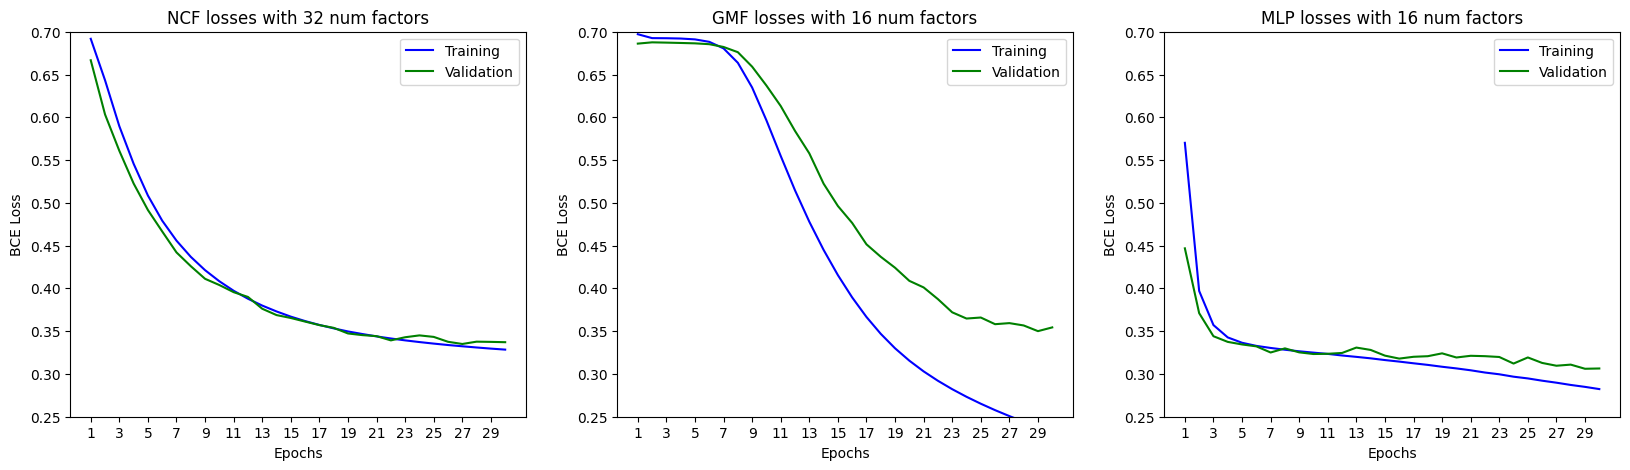

In [60]:
fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5))
ax1 = plot_losses2(nmf_model, nmf_losses['train loss'], nmf_losses['valid loss'], ax1)
ax2 = plot_losses2(gmf_model, gmf_losses['train loss'], gmf_losses['valid loss'], ax2)
ax3 = plot_losses2(mlp_model, mlp_losses['train loss'], mlp_losses['valid loss'], ax3)


# Metrics evaluation

In [45]:
from tqdm import tqdm
import pandas as pd

def model_evaluation(models_dict, test_loader, k_range = range(5, 15), device = torch.device("cpu")): #the function expects a dict {"model name": model}
  for key in models_dict:
    models_dict[key] = models_dict[key].to(device)

  HR = np.zeros((len(k_range), len(models_dict)))
  NDCG = np.zeros((len(k_range), len(models_dict)))
  for k in tqdm(range(0, k_range.stop - k_range.start)):
    for model_index, key in enumerate(models_dict):
      HR[k, model_index], NDCG[k, model_index] = metrics(models_dict[key], test_loader, k + 1, device)

  HR_result = pd.DataFrame(data = HR, columns = models_dict.keys(), index = k_range)
  NDCG_result = pd.DataFrame(data = NDCG, columns = models_dict.keys(), index = k_range)
  return HR_result, NDCG_result

In [61]:
mlp_model = torch.load(MODEL_PATH + "MLP16.pt", map_location = device)
gmf_model = torch.load(MODEL_PATH + "GMF16.pt", map_location = device)
nmf_model = torch.load(MODEL_PATH + "NCF32.pt", map_location = device)
mlp_model = mlp_model.to(device)
gmf_model = gmf_model.to(device)
nmf_model = nmf_model.to(device)

In [65]:
models_dict = {"GMF": gmf_model, "MLP": mlp_model, "NeuMF": nmf_model}
HR, NDCG = model_evaluation(models_dict, test_loader, device = device)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


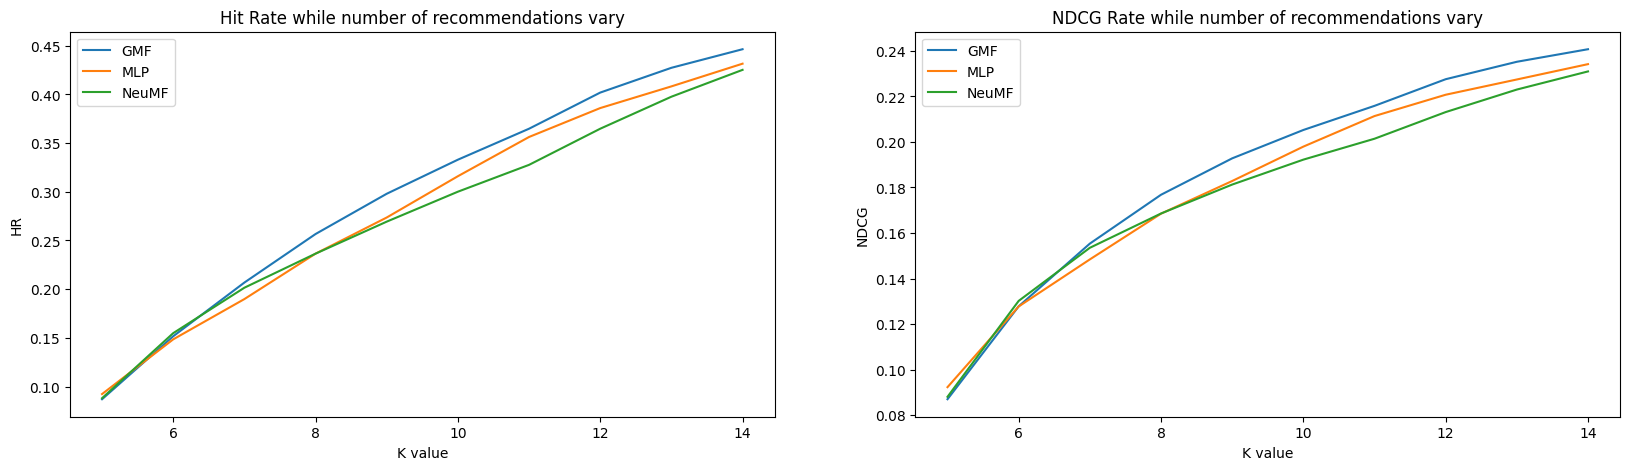

In [66]:
import matplotlib.pyplot as plt
fig, (hr_ax, ndcg_ax) = plt.subplots(1,2, figsize = (20, 5))

for i in HR.columns:
  hr_ax.plot(HR[i], label = i)
  ndcg_ax.plot(NDCG[i], label = i)

hr_ax.set_title("Hit Rate while number of recommendations vary")
ndcg_ax.set_title("NDCG Rate while number of recommendations vary")
hr_ax.set_ylabel("HR")
hr_ax.set_xlabel("K value")
ndcg_ax.set_ylabel("NDCG")
ndcg_ax.set_xlabel("K value")
hr_ax.legend()
ndcg_ax.legend()
plt.show()